In [1]:
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from test_utils import *

Work based on **InPrivate Digging** paper: https://ieeexplore.ieee.org/document/8486352

        
**Differential privacy for a single tree** proposed in the paper was implemented using [sklearn](https://scikit-learn.org/stable/) library. Namely we introduce 2 new parameters to [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) (role of all other parameters stays the same):
- **epsilon_dp_leaves** : *float, optional(default=None)*
Parameter $\epsilon_2$ from the paper (see for example Algorithm 1 or equation (15)).
Note that by default no noise is added, i.e. we fit normal gradient boosting trees.
- **epsilon_dp_internal_nodes**: *float, optional(default=-1)*
Parameter $\epsilon_1$ from the paper (see for example Algorithm 1 or equation (10)).
Note that by default no noise is added, i.e. we fit normal gradient boosting trees.

The following scripts were modified in the sklearn source code:
- *sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py*
- *sklearn/ensemble/_hist_gradient_boosting/grower.py*  (adding noise to leaves takes place in method *_finalize_leaf* of class *TreeNode*)
- *sklearn/ensemble/_hist_gradient_boosting/splitting.pyx* (exponential mechanism was added to class *Splitter*)

The **peer2peer protocol** was tested using [XGBoost](https://xgboost.readthedocs.io/en/latest/) library, see script *fedXGBclass.py*. By peer2peer we mean passing of the trees between clients. In the script there is an example for 2 clients, that build trees sequentially and pass those back and forth (note that data is still stored locally, as the communication protocol itself was not implemented).

DISCLAIMER: note that both implementations (i.e. using xgboot and sklearn) are meant more as a proof of concept and not as a deployment ready code! Nevertheless, both could surely be extended to production level code, and that can be the goal of future projets...

#### Below the newly introduced diff. privacy parameters are tested on two different datasets: Iris and [Telco churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn). We compare perfomance of Gradient boosting models with and without differential privacy. We hope to observe the privacy-utility tradeoff, i.e. by adding more noise (lower epsilon) the perfomance gets worse.

## 1) Iris dataset

In [3]:
X_iris, y_iris = load_iris(return_X_y=True)

### 1.1) Regressor + differential privacy

Accuracy w.r.t. leaf noise:  [0.31333333333333335, 0.49333333333333335, 0.8466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9400000000000001, 0.9400000000000001, 0.9133333333333333, 0.9400000000000001, 0.9466666666666669]
Accuracy w.r.t. inner node noise:  [0.96, 0.9733333333333334, 0.9666666666666668, 0.9533333333333334, 0.96, 0.9600000000000002, 0.9533333333333334, 0.9466666666666667, 0.96, 0.9666666666666668]


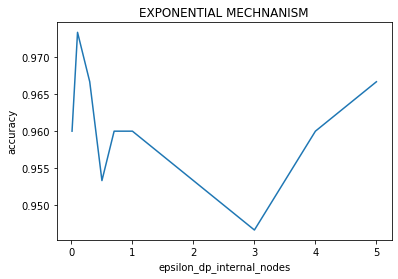

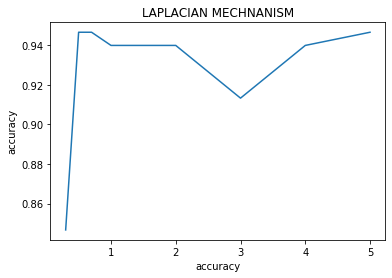

In [4]:
accuracy_dp_check(HistGradientBoostingRegressor, X_iris, y_iris, threshold_fun=threshold_iris)

### 1.2) Classifier + differential privacy

Accuracy w.r.t. leaf noise:  [0.23333333333333334, 0.5866666666666667, 0.4, 0.4066666666666666, 0.5466666666666666, 0.5266666666666666, 0.3866666666666667, 0.5533333333333335, 0.5133333333333334, 0.58]
Accuracy w.r.t. inner node noise:  [0.9666666666666666, 0.96, 0.9600000000000002, 0.9466666666666667, 0.9533333333333334, 0.9466666666666667, 0.9533333333333335, 0.9533333333333334, 0.9466666666666667, 0.9399999999999998]


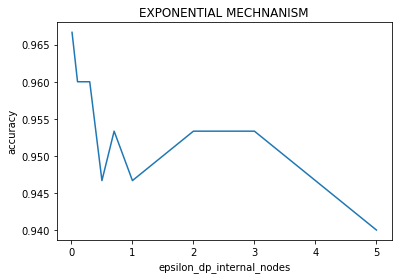

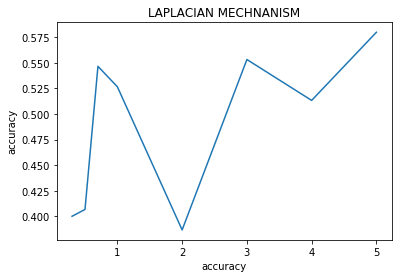

In [5]:
accuracy_dp_check(HistGradientBoostingClassifier, X_iris, y_iris, threshold_fun=threshold_iris)

### 1.3) Regressor

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)
reg_iris = HistGradientBoostingRegressor(max_bins=255).fit(X_train, y_train)
reg_pred = np.vectorize(threshold_iris)(reg_iris.predict(X_test))
print("Accuracy :", accuracy_score(y_test, reg_pred))

Accuracy : 1.0


### 1.4) Classifier

In [7]:
cls_iris = HistGradientBoostingClassifier(max_bins=255).fit(X_train, y_train)
print("Accuracy :", accuracy_score(y_test, cls_iris.predict(X_test)))

Accuracy : 1.0


## 2) Telco dataset
Note that here we have binary prediction (in Iris we have a 3-class prediciton).

In [2]:
data = pd.read_csv("../../Federated_start/federated-learning-metod/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float32')
categorical_cols = list(set(list(data.columns)) - set(['tenure', 'MonthlyCharges', 'TotalCharges', 'customerID']))
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data_encoded.TotalCharges = pd.to_numeric(data_encoded['TotalCharges'],errors='coerce')

X_telco, y_telco = data_encoded.loc[:, ~data_encoded.columns.isin(['Churn_Yes', 'customerID'])], data_encoded.Churn_Yes

### 2.1) Regressor + diff. privacy

Accuracy w.r.t. leaf noise:  [0.7435777106587522, 0.7704124056390735, 0.7749530211626556, 0.7938375056455256]
Accuracy w.r.t. inner node noise:  [0.7966794228659915, 0.7951186366862378, 0.7969602877605005, 0.7963937189496096]
F1 w.r.t. inner node noise:  [0.5455681008059159, 0.5462279289537363, 0.5451211537046322, 0.5477793238698003]


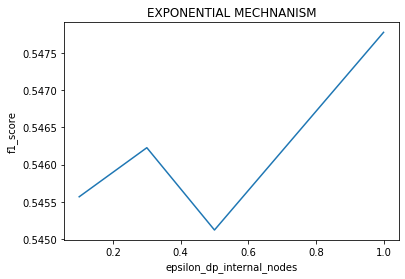

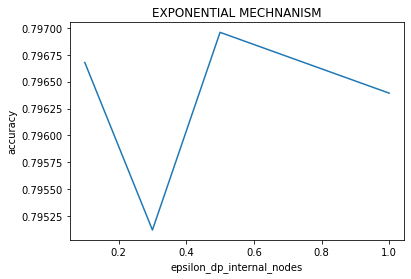

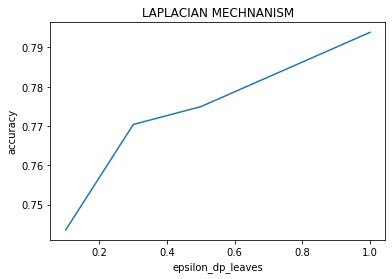

In [3]:
accuracy_dp_check(HistGradientBoostingRegressor, X_telco.values, y_telco.values, 
                          threshold_fun=threshold_telco, epsilons=[0.1,0.3,0.5,1], f1=True)

### 2.2) Classifier + diff. privacy

Accuracy w.r.t. leaf noise:  [0.6613607127879219, 0.7005542696302987, 0.7146155598748305, 0.7540825214529969]
Accuracy w.r.t. inner node noise:  [0.7959654655139041, 0.7966781122975676, 0.7983794317375315, 0.8006524614491258]
F1 w.r.t. inner node noise:  [0.546050332848435, 0.5533628357499192, 0.5577015013509147, 0.5688460114397816]


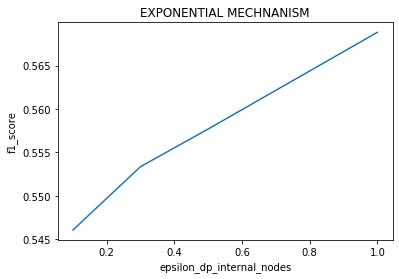

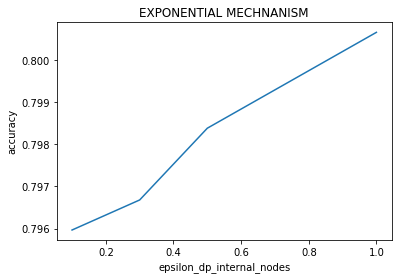

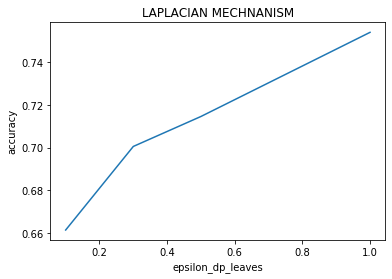

In [4]:
accuracy_dp_check(HistGradientBoostingClassifier, X_telco.values, y_telco.values, 
                         threshold_fun=threshold_telco, epsilons=[0.1,0.3,0.5,1], f1=True)

### 2.3) Regressor

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_telco, y_telco, test_size=0.2, random_state=42)
reg = HistGradientBoostingRegressor(max_bins=255).fit(X_train, y_train)
reg_pred = np.vectorize(threshold_telco)(reg.predict(X_test))
# regressor is false since I do thresholding 
eval_preds(y_test, reg_pred, regressor=False)

Accuracy 0.8041
Baseline accuracy 0.7353
F1 score 0.5868


array([[937,  99],
       [177, 196]])

### 2.4) Classifier

In [7]:
cls_noise = HistGradientBoostingClassifier(max_bins=255).fit(X_train, y_train)
eval_preds(y_test, cls_noise.predict(X_test), regressor=False)

Accuracy 0.807
Baseline accuracy 0.7353
F1 score 0.6058


array([[928, 108],
       [164, 209]])

## 3) Iris in-sample

### 3.1) Regressor

We observe nice tradeoff between utility and privacy. But does regressor make sense in Iris setting (since we have a multiclass prediction problem)?

R^2 w.r.t. leaf noise:  [-488052.8308892157, -132.37427974141102, 0.8744412835768938, 0.9291413601314176, 0.9695716451920606, 0.9756327015057582, 0.9780866883854376, 0.9783057305548937]
R^2 w.r.t. inner node noise:  [0.9621734609458363, 0.9611559987442405, 0.9621297869909178, 0.9633579104928434, 0.9637934085656479, 0.9660133306634379, 0.9680770227666556, 0.9702276324319812]


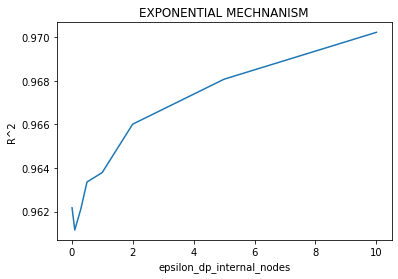

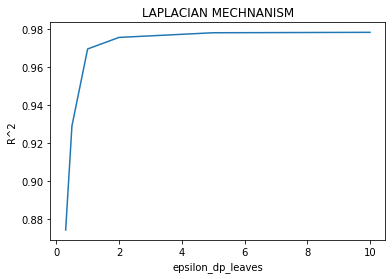

In [6]:
run_model(HistGradientBoostingRegressor, X_iris, y_iris)

### 3.2) Classifier

For Laplacian mechanism we do not observe utility-privacy tradeoff. Kinda makes sense, since theory used for adding noise to the leaves in the InPrivate Digging paper supports regression trees...

R^2 w.r.t. leaf noise:  [0.38133333333333336, 0.35466666666666674, 0.5479999999999999, 0.394, 0.3333333333333333, 0.5266666666666666, 0.528, 0.4966666666666667]
R^2 w.r.t. inner node noise:  [0.9933333333333334, 0.9933333333333334, 0.9933333333333334, 0.9933333333333334, 0.9933333333333334, 0.9946666666666667, 0.9966666666666667, 1.0]


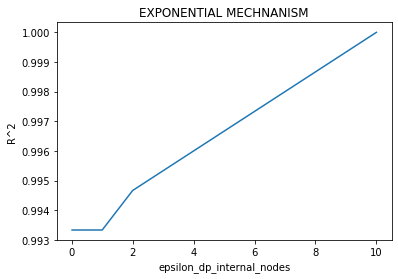

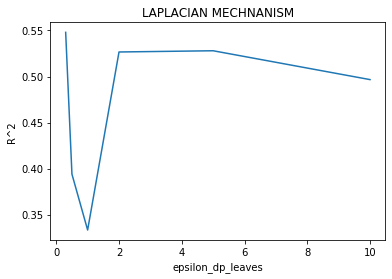

In [8]:
run_model(HistGradientBoostingClassifier, X_iris, y_iris)

## 4) Ideas for future improvements/extensions:

- Looking at the plots below, the privacy-utility tradeoff is in general nicely observed for Laplacian mechanism, i.e. the higher the epsilon (meaning less privacy we require), the more accurate our model. This is not the case for exponential mechanism. Should be worth exploring whether or not that is due to the bug in the code (see splitting.pyx in sklearn source code) or due to the nature of the mechanism itself.
- Implementation of the exponential mechanism in splitting.pyx is not the most efficient, i.e. it takes significantly longer to fit a model when we add noise to the inner nodes. Need to investigate where this perfomance overhead is occuring and try to improve it. Note that most of the code of splitting.pyx is in [cython](https://cython.org/), which gave me quite some problems when trying to retrieve values of all candidate gains.
- Get good understanding of difference between classification trees and regression trees (and figure out if that is the difference between HistGradientBoostingClassifier and HistGradientBoostingRegressor). Note that theory in both the [InPrivate Digging](https://ieeexplore.ieee.org/document/8486352) paper and [XGBoost](https://arxiv.org/pdf/1603.02754.pdf) paper was developed for regression trees.
- Can HistGradientBoostingRegressor be used for classification purposes? Above it is used as such, and to obtain final labels, threshold function is applied (which is not the usual way of doing it...). 